In [3]:
# Hide tensorflow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns 
from upload_overleaf.upload import upload
import tensorflow as tf


In [4]:
print(f'TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}')

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


The following cell reads the parquet files created by raw2parquet.py. 

It joins the prices and coacs tables on the ticker and date columns. It also creates a new column called OldNoOfStocks, which is the number of stocks before the stock split/dividend. If there is not a match in the coacs table, the OldNoOfStocks is set to 1. The StockOpen, StockHigh, StockLow, and StockClose columns are multiplied with OldNoOfStocks to get the adjusted price.

It applies the log transformation to the adjusted prices, and the calculates the log return for each ticker. The log return is calculated for the following time intervals: 1, 5, 10, 30, 60, 120, 240, and 390 minutes. 

In [5]:
lf_intraday = (
    pl.scan_parquet('prices.parquet')
    .join(pl.scan_parquet('coacs.parquet').select(['ticker','date','OldNoOfStocks']), on=['ticker', 'date'], how='left')
    # If there is not a match in the coacs table, the OldNoOfStocks is set to 1.
    .with_columns(pl.when(pl.col('OldNoOfStocks').is_null()).then(1).otherwise(pl.col('OldNoOfStocks')).alias('OldNoOfStocks'))
    # Multiply StockOpen, StockHigh, StockLow, and StockClose with OldNoOfStocks to get the adjusted price
    .with_columns([
        pl.col('StockClose') * pl.col('OldNoOfStocks').alias('StockClose')
    ])
    .with_columns([
        pl.col('ticker'),
        pl.col('date').alias('date'),
        pl.col('datetime').alias('datetime'),
        pl.col('StockClose').log().alias('log_close'),
        pl.col('StockVol').alias('volume')
    ])
    .sort(['ticker', 'datetime'])
    .select([
        'ticker',
        'date',
        'datetime',
        'log_close',
        'volume',
        (pl.col('log_close') - pl.col('log_close').shift(1)).over(pl.col('ticker')).alias('return_1min'),
        (pl.col('log_close') - pl.col('log_close').shift(5)).over(pl.col('ticker')).alias('return_5min'),
        (pl.col('log_close') - pl.col('log_close').shift(10)).over(pl.col('ticker')).alias('return_10min'),
        (pl.col('log_close') - pl.col('log_close').shift(30)).over(pl.col('ticker')).alias('return_30min'),
        (pl.col('log_close') - pl.col('log_close').shift(60)).over(pl.col('ticker')).alias('return_1h'),
        (pl.col('log_close') - pl.col('log_close').shift(120)).over(pl.col('ticker')).alias('return_2h'),
        (pl.col('log_close') - pl.col('log_close').shift(240)).over(pl.col('ticker')).alias('return_4h'),
        (pl.col('log_close') - pl.col('log_close').shift(390)).over(pl.col('ticker')).alias('return_1d')
    ])
)

In [6]:
# Join SP500 data with the intraday data, and calculate the excess market return
lf_intraday = (
    lf_intraday
    .join((lf_intraday.filter(pl.col('ticker') == 'US500')
    .select([
        pl.col('datetime').alias('datetime'),
        pl.col('log_close').alias('mkt_log_close'),
        pl.col('volume').alias('mkt_volume'),
        pl.col('return_1min').alias('mkt_return_1min'),
        pl.col('return_5min').alias('mkt_return_5min'),
        pl.col('return_10min').alias('mkt_return_10min'),
        pl.col('return_30min').alias('mkt_return_30min'),
        pl.col('return_1h').alias('mkt_return_1h'),
        pl.col('return_2h').alias('mkt_return_2h'),
        pl.col('return_4h').alias('mkt_return_4h'),
        pl.col('return_1d').alias('mkt_return_1d')
    ])
    ), on='datetime', how='left')
)

In [11]:
lf_intraday.collect()

ticker,date,datetime,log_close,volume,return_1min,return_5min,return_10min,return_30min,return_1h,return_2h,return_4h,return_1d,mkt_log_close,mkt_volume,mkt_return_1min,mkt_return_5min,mkt_return_10min,mkt_return_30min,mkt_return_1h,mkt_return_2h,mkt_return_4h,mkt_return_1d
str,date,"datetime[μs, Europe/Copenhagen]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""A""",2022-01-03,2022-01-03 14:30:00 CET,5.066322,5133.0,null,null,null,null,null,null,null,null,8.473032,1.3248692e7,null,null,null,null,null,null,null,null
"""A""",2022-01-03,2022-01-03 14:31:00 CET,5.064555,3131.0,-0.00206,null,null,null,null,null,null,null,8.473325,1.1563156e7,0.000293,null,null,null,null,null,null,null
"""A""",2022-01-03,2022-01-03 14:32:00 CET,5.063291,6794.0,-0.001185,null,null,null,null,null,null,null,8.473245,1.0750888e7,-0.000079,null,null,null,null,null,null,null
"""A""",2022-01-03,2022-01-03 14:33:00 CET,5.061772,1188.0,-0.002102,null,null,null,null,null,null,null,8.473828,1.1039396e7,0.000583,null,null,null,null,null,null,null
"""A""",2022-01-03,2022-01-03 14:34:00 CET,5.063038,2046.0,0.001041,null,null,null,null,null,null,null,8.474054,1.0115523e7,0.000226,null,null,null,null,null,null,null
"""A""",2022-01-03,2022-01-03 14:35:00 CET,5.060694,5267.0,-0.002381,-0.006687,null,null,null,null,null,null,8.474091,1.0813135e7,0.000038,0.001059,null,null,null,null,null,null
"""A""",2022-01-03,2022-01-03 14:36:00 CET,5.058155,4479.0,-0.00297,-0.007597,null,null,null,null,null,null,8.474522,9.602062e6,0.00043,0.001197,null,null,null,null,null,null
"""A""",2022-01-03,2022-01-03 14:37:00 CET,5.0579,2376.0,-0.000918,-0.00733,null,null,null,null,null,null,8.475185,1.0015592e7,0.000664,0.00194,null,null,null,null,null,null
"""A""",2022-01-03,2022-01-03 14:38:00 CET,5.061075,991.0,0.003393,-0.001835,null,null,null,null,null,null,8.474966,7.620992e6,-0.000219,0.001138,null,null,null,null,null,null


In [ ]:
# Subset every 60th row. This is done to reduce the size of the data for initial testing.
lf_intraday = lf_intraday.gather_every(n=60).lazy()

The following cell transforms the intraday data to daily data. It groups the data by date and ticker, and sums the volume to get the daily volume. It also calculates the daily return for each ticker.

In [7]:
 # Group by date and ticker and sum volumne to get daily volume
lf_daily = (
    lf_intraday
    .group_by(['ticker', 'date'])
    .agg(
        pl.last('datetime').alias('datetime'),
        pl.last('log_close').cast(pl.Float64),
        pl.sum('volume').cast(pl.Float64).alias('volume') # Sum volume to get daily volume
    )
    .group_by(['ticker', 'date']).last() # Select the last row in each group
    .sort(['ticker', 'date'])
    .select([
        'ticker',
        'date',
        'datetime',
        'log_close',
        'volume',
        (pl.col('log_close') - pl.col('log_close').shift(1)).over(pl.col('ticker')).alias('return_1d')
    ])
)

In [13]:
lf_daily.fetch(n_rows=10000)

ticker,date,datetime,log_close,volume,return_1d
str,date,"datetime[μs, Europe/Copenhagen]",f64,f64,f64
"""A""",2022-01-03,2022-01-03 20:59:00 CET,5.052928,1.297183e6,null
"""A""",2022-01-04,2022-01-04 20:59:00 CET,5.018537,2.180323e6,-0.034391
"""A""",2022-01-05,2022-01-05 20:59:00 CET,5.001258,2.191982e6,-0.017279
"""A""",2022-01-06,2022-01-06 20:59:00 CET,5.004751,2.223166e6,0.003493
"""A""",2022-01-07,2022-01-07 20:59:00 CET,4.977768,2.014664e6,-0.026984
"""A""",2022-01-10,2022-01-10 20:59:00 CET,4.977837,2.367967e6,0.000069
"""A""",2022-01-11,2022-01-11 20:59:00 CET,4.987981,2.017367e6,0.010144
"""A""",2022-01-12,2022-01-12 20:59:00 CET,5.007363,1.995822e6,0.019383
"""A""",2022-01-13,2022-01-13 20:59:00 CET,4.977905,1.467351e6,-0.029458


In [8]:
df_aapl = lf_daily.filter(pl.col('ticker') == 'AAPL').collect().to_pandas()

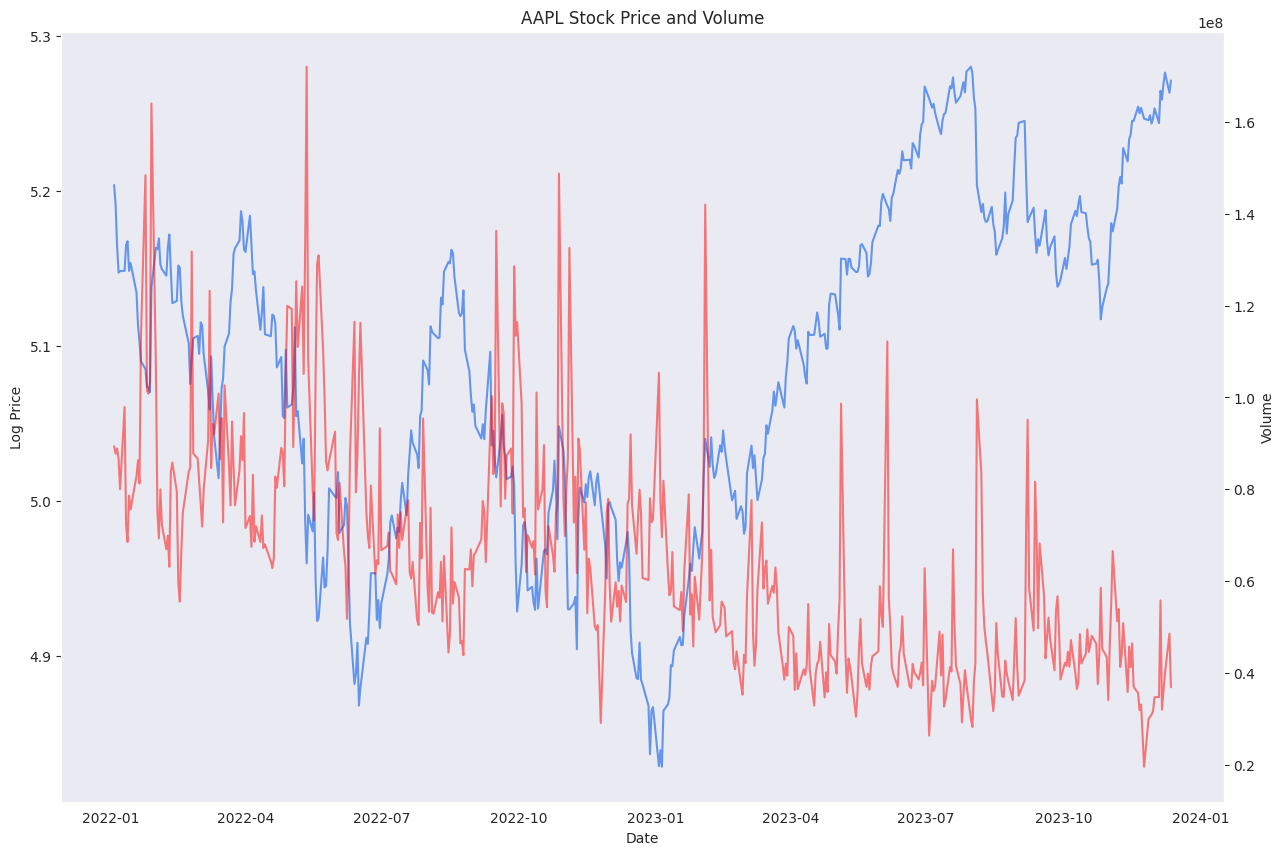

In [9]:
# Plot time series of StockClose
plt.figure(figsize=(15,10))
# Add second y-axis. Left is log price and right is return
ax = sns.lineplot(x='date', y='log_close', data=df_aapl, color='cornflowerblue')
ax2 = ax.twinx()
sns.lineplot(x='date', y='volume', data=df_aapl, color='red', ax=ax2, alpha=0.5)
# Disable grid
ax.grid(False)
ax2.grid(False)
ax.set_title('AAPL Stock Price and Volume')
ax.set_ylabel('Log Price')
ax2.set_ylabel('Volume')
ax.set_xlabel('Date')
upload(plt, "Master's Thesis", 'figures/aapl_test.png')